In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
import datetime

#import hvplot
#import hvplot.pandas
#import holoviews as hv
#hv.extension('bokeh')

In [2]:
src = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [3]:
df = pd.read_csv(src)

# extract the dates and make an array: 
dates = df.columns[4:-1]
#print(date)
dates_list = []
dates_ord_list = []
for d in dates:
    #print(d)
    d_s = d.split('/')
    #print(d_s, int(d_s[0]))
    dt = datetime.date( month=int(d_s[0]),day=int(d_s[1]),year = 2000+int(d_s[2]) )
    dates_list.append(dt)
    #print(dt)
    dg = dt.toordinal()
    dates_ord_list.append(dg)
    #print(dg)
    
#print(dates_list)
print(dates_ord_list[0])
dates_ord_ra = np.asarray(dates_ord_list)
dates_int = dates_ord_ra-dates_ord_ra[0]
#print(dates_int)


737446


In [4]:
print(df.columns[0:4])
df.rename(columns={'Country/Region': 'country', 'Province/State': 'state',
                   'Lat': 'lat', 'Long': 'lon'}, inplace = True)

df_US = df[(df.country=='US') & (df.state!='Diamond Princess') & 
         (df.state!='Grand Princess')].reset_index(drop=True)

# df.columns = df.columns[0:4].append(pd.to_datetime(df.columns[4:]))

# state = df.state.str.split(',').apply(lambda x: x[-1])
# county = df.state.str.split(',').apply(lambda x: x[0])
# county[~df.state.str.contains(',')] = None

#print(df.country)

Index(['Province/State', 'Country/Region', 'Lat', 'Long'], dtype='object')


In [5]:
#print(df.loc[df.country=='US'])
#print(df.loc[df.state=='New York'])
#print(df.loc[df.state=='California']

def make_time_dct(df,ind):
    n_cases_tot = df.iloc[ind].values[4:-1]
    n_cases_daily = np.diff(n_cases_tot)
    
    #print(n_cases_tot)
    #print(n_cases_daily)
    #print(len(n_cases_tot),len(n_cases_daily))
    place_name = df.iloc[ind]['country'] #+ ',' + df.iloc[ind]['state']
    dct = {'place_name':place_name, 'lat':df.iloc[ind].lat,'lon':df.iloc[ind].lon,
       'days':dates_int,'n_cases_tot':n_cases_tot,'n_cases_daily':n_cases_daily }
    return dct


Text(0,0.5,'log(10) N confirmed cases')

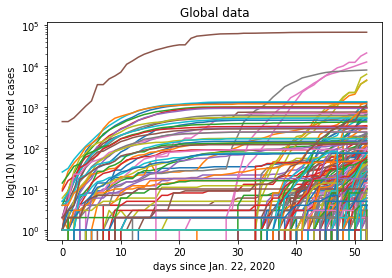

In [7]:
dct_list = []
for ind in range(len(df)):
    dct = make_time_dct(df,ind)
    dct_list.append(dct)

for ind in range(len(df)):
    dct = dct_list[ind]
    plt.semilogy(dct['days'],dct['n_cases_tot'])

ttltxt = 'Global data'
plt.title(ttltxt)
plt.xlabel('days since Jan. 22, 2020')
plt.ylabel('log(10) N confirmed cases')
#plt.ylim(0,2000)

245


Text(0,0.5,'log(10) N confirmed cases')

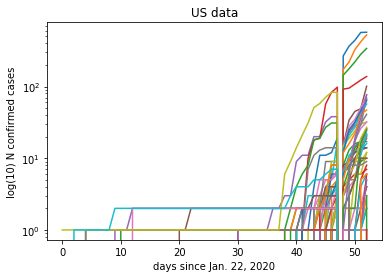

In [8]:
print(len(df_US))

dct_list_US = []
for ind in range(len(df_US)):
    dct = make_time_dct(df_US,ind)
    dct_list_US.append(dct)

for ind in range(len(df_US)):
    dct = dct_list_US[ind]
    plt.semilogy(dct['days'],dct['n_cases_tot'])
    
ttltxt = 'US data'
plt.title(ttltxt)
plt.xlabel('days since Jan. 22, 2020')
plt.ylabel('log(10) N confirmed cases')

10 43


Text(0,0.5,'log_2 N confirmed cases')

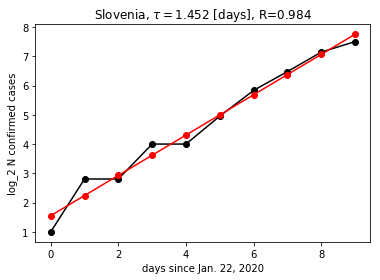

In [14]:
from scipy.signal import savgol_filter as savgol

def is_odd(num):
    return num % 2 != 0

def fit_log2(dct):
    x = np.array(dct['days'][dct['n_cases_tot']>0].tolist())
    y = np.array(dct['n_cases_tot'][dct['n_cases_tot']>0].tolist())
    #print(x)
    #print(y)

    # try savgol filter to determine where curvature goes neg
    len_y = len(y)
    wl = int(len_y/2)
    if is_odd(wl)==0:
        wl= wl+1

    y_sg = savgol(y,wl,2)
    y_sg_2diff = np.diff(np.diff(y_sg))
    #print(y_sg_2diff)

    lg2y = np.log2(y)

    # fit 
    ind_1stCase = np.nonzero(y)[0][-1]+1
    print(dct['days'][ind_1stCase],x[0])
    #print(ind_1st_non0)
    x_shift = x-x[0]
    consts = np.polyfit(x_shift, lg2y, 1)
    log2N0 = consts[1]
    tau = 1/consts[0]
    #print(consts)
    y_fit = 2**log2N0 * 2**(x_shift/tau)
    log2_yfit = log2N0 + x_shift/tau

    R = sum((lg2y-log2_yfit)**2)
    
    dct['x']=x  # dct = {} defines a new one, overwriting the old ! 
    dct['y']=y
    dct['y_savgol']=y_sg
    dct['lg2y']=lg2y
    dct['x_shift']=x_shift
    dct['tau']=tau
    dct['y_fit']=y_fit    
    dct['log2_yfit']=log2_yfit
    dct['ind_1stCase']=ind_1stCase 
    dct['Resid'] = R
    
    return dct


# =======================================
ind = 77 # 27 
dct = make_time_dct(df,ind)
dct = fit_log2(dct)
#print(dct)

x = dct['x_shift']
lg2y = dct['lg2y']
log2_yfit = dct['log2_yfit']
tau = dct['tau']
R = dct['Resid']

ax0 = plt.figure()
plt.plot(x,lg2y,'ko')
plt.plot(x,lg2y,'k-')
plt.plot(x,log2_yfit,'ro')
plt.plot(x,log2_yfit,'r-')
#plt.plot(dct['days'][0:-2],dct['n_cases_daily'], 'r.')
ttltxt = dct['place_name'] + r', $\tau=$' + str(round(tau,3)) + ' [days], R=' + str(round(R,3))
plt.title(ttltxt)
plt.xlabel('days since Jan. 22, 2020')
plt.ylabel('log_2 N confirmed cases')
